## Import Libraries

In [44]:
import numpy as np
from numpy.linalg import eig
from scipy.optimize import fsolve
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import drive
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Load in Dataset

In [45]:
# load in full dataset
dfBondInfo = pd.read_csv('/content/drive/My Drive/APM466/Assignment 1/Bond Information.csv')
dfBondPrice = pd.read_csv('/content/drive/My Drive/APM466/Assignment 1/Bond Price.csv')

# 10 selected bonds (date range: 2024/01/08 to 2024/01/19)
#lstSelectedBonds = ['CA135087B451', 'CA135087P659', 'CA135087Q640', 'CA135087R226', 'CA135087L930',
#                    'CA135087M847', 'CA135087P733', 'CA135087P576', 'CA135087Q491', 'CA135087Q988']
lstSelectedBonds = ['CA135087J546', 'CA135087J967', 'CA135087K528', 'CA135087K940', 'CA135087L518',
                    'CA135087L930', 'CA135087M847', 'CA135087N837', 'CA135087P576', 'CA135087Q491', 'CA135087Q988']
dfBondInfo10 = dfBondInfo[dfBondInfo['ISIN'].isin(lstSelectedBonds)].set_index('ISIN')
dfBondPrice10 = dfBondPrice[dfBondPrice['ISIN'].isin(lstSelectedBonds)].set_index('ISIN').reindex(lstSelectedBonds)

# organize bond info into a dictionary
dictBondInfo10 = {}
date_format = '%m/%d/%Y'
for i in range(len(lstSelectedBonds)):
  bond = lstSelectedBonds[i]
  bondInfo = dfBondInfo10.loc[bond]
  coupon = bondInfo['Coupon']
  dtIssue = datetime.strptime(bondInfo['Issue Date'], date_format).date()
  dtMaturity = datetime.strptime(bondInfo['Maturity Date'], date_format).date()
  dictBondInfo10[bond] = {'Coupon': coupon, 'Issue Date': dtIssue, 'Maturity Date': dtMaturity}


In [46]:
dictBondInfo10

{'CA135087J546': {'Coupon': 0.0225,
  'Issue Date': datetime.date(2018, 10, 5),
  'Maturity Date': datetime.date(2024, 3, 1)},
 'CA135087J967': {'Coupon': 0.015,
  'Issue Date': datetime.date(2019, 4, 5),
  'Maturity Date': datetime.date(2024, 9, 1)},
 'CA135087K528': {'Coupon': 0.0125,
  'Issue Date': datetime.date(2019, 10, 11),
  'Maturity Date': datetime.date(2025, 3, 1)},
 'CA135087K940': {'Coupon': 0.005,
  'Issue Date': datetime.date(2020, 4, 3),
  'Maturity Date': datetime.date(2025, 9, 1)},
 'CA135087L518': {'Coupon': 0.0025,
  'Issue Date': datetime.date(2020, 10, 9),
  'Maturity Date': datetime.date(2026, 3, 1)},
 'CA135087L930': {'Coupon': 0.01,
  'Issue Date': datetime.date(2021, 4, 16),
  'Maturity Date': datetime.date(2026, 9, 1)},
 'CA135087M847': {'Coupon': 0.0125,
  'Issue Date': datetime.date(2021, 10, 15),
  'Maturity Date': datetime.date(2027, 3, 1)},
 'CA135087N837': {'Coupon': 0.0275,
  'Issue Date': datetime.date(2022, 5, 13),
  'Maturity Date': datetime.date(20

## Calculate Dirty Price

In [47]:
# helper functions
def calc_dirty_price(dtCurrent, dtNextCoupon, fltCleanPrice, fltCoupon, FV=100):
  dtPreviousCoupon = dtNextCoupon - relativedelta(months=6)
  n = (dtCurrent-dtPreviousCoupon).days # number of days since the last payment
  fltDirtyPrice = fltCleanPrice + (n/365)*fltCoupon*FV
  return fltDirtyPrice


def find_next_coupon_date(dtCurrent, dtMaturity, return_list=False):
  lstCouponDates = []
  dtCoupon = dtMaturity
  while dtCoupon >= dtCurrent:
    lstCouponDates.append(dtCoupon)
    dtCoupon = dtCoupon - relativedelta(months=6)

  lstCouponDates = lstCouponDates[::-1] # sort coupon payment dates from smallest to largest
  if return_list is True:
    return lstCouponDates
  else:
    return lstCouponDates[0]

In [48]:
lstCurrentDates = list(dfBondPrice10.columns)
dfBondDirtyPrice10 = pd.DataFrame(index=lstSelectedBonds, columns=lstCurrentDates)

for bond in dfBondDirtyPrice10.index:
  lstCleanPrices = list(dfBondPrice10.loc[bond])
  lstDirtyPrices = []
  fltCoupon = dictBondInfo10[bond]['Coupon']
  dtMaturity = dictBondInfo10[bond]['Maturity Date']
  for i in range(len(lstCurrentDates)):
    dtCurrent = datetime.strptime(lstCurrentDates[i], '%Y-%m-%d').date()
    dtNextCoupon = find_next_coupon_date(dtCurrent, dtMaturity)
    fltCleanPrice = lstCleanPrices[i]
    fltDirtyPrice = calc_dirty_price(dtCurrent, dtNextCoupon, fltCleanPrice, fltCoupon, 100)
    lstDirtyPrices.append(fltDirtyPrice)
  dfBondDirtyPrice10.loc[bond] = lstDirtyPrices


In [49]:
dfBondPrice10

,2024-01-08,2024-01-09,2024-01-10,2024-01-11,2024-01-12,2024-01-15,2024-01-16,2024-01-17,2024-01-18,2024-01-19
ISIN,,,,,,,,,,
CA135087J546,99.630,99.640,99.650,99.661,99.670,99.687,99.680,99.683,99.708,99.720
CA135087J967,97.960,97.980,97.985,97.982,98.021,98.054,97.974,97.975,97.999,98.007
CA135087K528,96.460,96.482,96.552,96.576,96.661,96.715,96.540,96.448,96.495,96.460
CA135087K940,94.340,94.370,94.380,94.430,94.490,94.490,94.420,94.250,94.240,94.220
CA135087L518,92.862,92.860,92.844,92.856,93.023,93.008,92.796,92.570,92.546,92.545
CA135087L930,93.460,93.440,93.550,93.530,93.600,93.570,93.400,93.120,93.080,93.070
CA135087M847,93.282,93.301,93.245,93.186,93.467,93.493,93.141,92.856,92.753,92.764
CA135087N837,97.580,97.591,97.603,97.520,97.740,97.772,97.441,97.092,96.956,96.947
CA135087P576,100.500,100.480,100.439,100.328,100.637,100.673,100.220,99.834,99.662,99.623


In [50]:
dfBondDirtyPrice10

,2024-01-08,2024-01-09,2024-01-10,2024-01-11,2024-01-12,2024-01-15,2024-01-16,2024-01-17,2024-01-18,2024-01-19
CA135087J546,100.425205,100.44137,100.457534,100.474699,100.489863,100.525356,100.524521,100.533685,100.564849,100.583014
CA135087J967,98.490137,98.514247,98.523356,98.524466,98.567575,98.612904,98.537014,98.542123,98.570233,98.582342
CA135087K528,96.901781,96.927205,97.00063,97.028055,97.116479,97.180753,97.009178,96.920603,96.971027,96.939452
CA135087K940,94.516712,94.548082,94.559452,94.610822,94.672192,94.676301,94.607671,94.439041,94.430411,94.411781
CA135087L518,92.950356,92.949041,92.933726,92.946411,93.114096,93.101151,92.889836,92.664521,92.641205,92.64089
CA135087L930,93.813425,93.796164,93.908904,93.891644,93.964384,93.942603,93.775342,93.498082,93.460822,93.453562
CA135087M847,93.723781,93.746205,93.69363,93.638055,93.922479,93.958753,93.610178,93.328603,93.229027,93.243452
CA135087N837,98.551918,98.570452,98.589986,98.514521,98.742055,98.796658,98.473192,98.131726,98.00326,98.001795
CA135087P576,101.736986,101.726575,101.695164,101.593753,101.912342,101.97711,101.533699,101.157288,100.994877,100.965466
CA135087Q491,100.88863,100.877534,100.886438,100.725342,101.064247,101.120959,100.659863,100.218767,100.047671,100.016575


## Q4(a): YTM Calculation

### YTM Curve

In [51]:
# helper functions
def convert_years(dtCurrent, dtCoupon):
  n_days = (dtCoupon - dtCurrent).days
  n_yrs = n_days / 365
  return n_yrs


def convert_days(dtCurrent, dtCoupon):
  n_days = (dtCoupon - dtCurrent).days
  return n_days


# find the YTM such that PV (discounted CF) < Dirty Price
def find_upper_rate(fltDirtyPrice, fltCoupon, FV, lstCashFlows, lstYears, step=0.001):
  fltGuess = fltCoupon
  npCF = np.array(lstCashFlows)
  npYrs = np.array(lstYears)
  while True:
    npDiscount = np.exp(-(npYrs*fltGuess)) # exp(-rT)
    PV = np.sum(npCF*npDiscount)
    if PV < fltDirtyPrice:
      return (fltGuess, PV)
    else:
      fltGuess += step


# find the YTM such that PV (discounted CF) > Dirty Price
def find_lower_rate(fltDirtyPrice, fltCoupon, FV, lstCashFlows, lstYears, step=0.001):
  fltGuess = fltCoupon
  npCF = np.array(lstCashFlows)
  npYrs = np.array(lstYears)
  while fltGuess > 0:
    npDiscount = np.exp(-(npYrs*fltGuess)) # exp(-rT)
    PV = np.sum(npCF*npDiscount)
    if PV > fltDirtyPrice:
      return (fltGuess, PV)
    else:
      fltGuess -= step


def calc_YTM(dtCurrent, dtMaturity, fltDirtyPrice, fltCoupon, FV):
  lstCouponDates = find_next_coupon_date(dtCurrent, dtMaturity, return_list=True)
  lstYears = [convert_years(dtCurrent, dtCoupon) for dtCoupon in lstCouponDates]
  lstCashFlows = [(fltCoupon*FV/2) for _ in range(len(lstYears))]
  lstCashFlows[-1] += FV
  fltUpperRate, fltLowerPV = find_upper_rate(fltDirtyPrice, fltCoupon, FV, lstCashFlows, lstYears)
  fltLowerRate, fltUpperPV = find_lower_rate(fltDirtyPrice, fltCoupon, FV, lstCashFlows, lstYears)
  # perform linear interpolation - YTM
  fltYTM = fltUpperRate*((fltUpperPV-fltDirtyPrice)/(fltUpperPV-fltLowerPV)) + fltLowerRate*((fltDirtyPrice-fltLowerPV)/(fltUpperPV-fltLowerPV))
  return fltYTM



def findYTM(fltDirtyPrice, fltCoupon, FV, lstCashFlows, lstYears):
  fltGuess = fltCoupon
  npCF = np.array(lstCashFlows)
  npYrs = np.array(lstYears)
  #print(npYrs)
  #print(npCF)

  def equation(r):
    npDiscount = np.exp(-r*npYrs) # exp(-rT)
    PV = np.sum(npCF*npDiscount)
    return PV - fltDirtyPrice

  solution = fsolve(equation, fltGuess)
  return solution[0]


def calc_YTM_V2(dtCurrent, dtMaturity, fltDirtyPrice, fltCoupon, FV):
  lstCouponDates = find_next_coupon_date(dtCurrent, dtMaturity, return_list=True)
  lstYears = [convert_years(dtCurrent, dtCoupon) for dtCoupon in lstCouponDates]
  lstCashFlows = [(fltCoupon*FV/2) for _ in range(len(lstYears))]
  lstCashFlows[-1] += FV
  fltYTM = findYTM(fltDirtyPrice, fltCoupon, FV, lstCashFlows, lstYears)
  return fltYTM


In [52]:
npYears=np.array([0.14520548, 0.64931507, 1.14520548, 1.64931507])
npCF=np.array([  0.25,   0.25,   0.25, 100.25])
np.sum(npCF*np.exp(-0.040412*npYears))

94.51669566650793

In [53]:

dfBondYTM10 = pd.DataFrame(index=lstSelectedBonds, columns=lstCurrentDates)
lstCurrentDates = list(dfBondYTM10.columns)
FV = 100
for bond in dfBondYTM10.index:
  fltCoupon = dictBondInfo10[bond]['Coupon']
  dtMaturity = dictBondInfo10[bond]['Maturity Date']
  lstYTM = []
  for i in range(len(lstCurrentDates)):
    dtCurrent = datetime.strptime(lstCurrentDates[i], '%Y-%m-%d').date()
    fltDirtyPrice = dfBondDirtyPrice10.loc[bond][lstCurrentDates[i]]
    fltYTM = calc_YTM_V2(dtCurrent, dtMaturity, fltDirtyPrice, fltCoupon, FV)
    lstYTM.append(fltYTM)
  dfBondYTM10.loc[bond] = lstYTM


In [54]:
dfBondYTM10

,2024-01-08,2024-01-09,2024-01-10,2024-01-11,2024-01-12,2024-01-15,2024-01-16,2024-01-17,2024-01-18,2024-01-19
CA135087J546,0.047823,0.047613,0.047395,0.047095,0.046932,0.047191,0.048307,0.048649,0.047149,0.046702
CA135087J967,0.046631,0.046449,0.046503,0.046685,0.046198,0.04607,0.047507,0.047633,0.047383,0.047394
CA135087K528,0.044062,0.043937,0.043374,0.043229,0.042524,0.042244,0.043935,0.044865,0.044507,0.044912
CA135087K940,0.040412,0.040277,0.040271,0.040006,0.039675,0.03985,0.040365,0.041537,0.041664,0.041857
CA135087L518,0.037093,0.037147,0.037272,0.037256,0.036457,0.036664,0.037785,0.038982,0.039152,0.039205
CA135087L930,0.035771,0.035879,0.035456,0.035564,0.035303,0.035505,0.036231,0.037414,0.037608,0.037678
CA135087M847,0.034947,0.0349,0.035114,0.035339,0.034381,0.034348,0.035595,0.036613,0.036996,0.036979
CA135087N837,0.034293,0.034266,0.034235,0.034484,0.033843,0.033763,0.034744,0.035782,0.036193,0.036226
CA135087P576,0.033398,0.033449,0.033553,0.033836,0.033045,0.03295,0.034112,0.035107,0.035553,0.035654
CA135087Q491,0.032794,0.03284,0.032841,0.033234,0.032473,0.032404,0.033492,0.034539,0.034961,0.035056


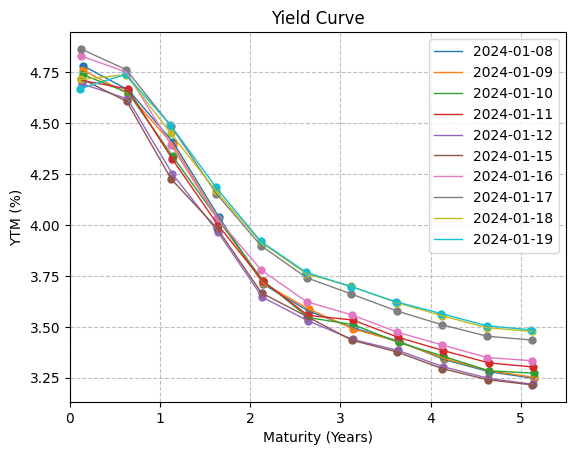

In [55]:
for strDate in dfBondYTM10.columns:
  dtDate = datetime.strptime(strDate, '%Y-%m-%d').date()
  npYTM = np.array(list(dfBondYTM10[strDate])) * 100
  lstMaturity = []
  for bond in dfBondYTM10.index:
    fltYears = convert_years(dtDate, dictBondInfo10[bond]['Maturity Date'])
    lstMaturity.append(fltYears)
  plt.plot(lstMaturity, npYTM, label=strDate, linewidth=1)
  plt.scatter(lstMaturity, npYTM, s=25)


plt.title('Yield Curve')
plt.xlabel('Maturity (Years)')
plt.ylabel('YTM (%)')
plt.xlim(0, 5.5)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.8)
plt.show()

### Interpolated YTM Curve

In [56]:
# helper functions

# get bond maturity information
def get_maturity_info(lstSelectedBonds, lstCurrentDates, dictBondInfo):
  dfBondMaturity = pd.DataFrame(index=lstSelectedBonds, columns=lstCurrentDates)
  for bond in dfBondMaturity.index:
    dtMaturity = dictBondInfo[bond]['Maturity Date']
    lstMaturity = []
    for i in range(len(lstCurrentDates)):
      dtCurrent = datetime.strptime(lstCurrentDates[i], '%Y-%m-%d').date()
      n_yrs = convert_years(dtCurrent, dtMaturity)
      lstMaturity.append(n_yrs)
    dfBondMaturity.loc[bond] = lstMaturity
  return dfBondMaturity

# interpolate curve
def interpolate_curve(dfData, lstYears, lstCurrentDates, dictInterpolate, dfBondMaturity):
  dfInterpolate = pd.DataFrame(index=lstYears, columns=lstCurrentDates)
  for strCurrent in lstCurrentDates:
      dtCurrent = datetime.strptime(strCurrent, '%Y-%m-%d').date()
      npMaturity = np.array(dfBondMaturity[strCurrent])
      npRate = np.array(dfData[strCurrent])
      lstRate = []
      n_yrs = 1
      for key, items in dictInterpolate.items():
        fltRate1, fltRate2 = npRate[items[0]], npRate[items[1]]
        fltDate1, fltDate2 = npMaturity[items[0]], npMaturity[items[1]]
        fltRate = fltRate1 * ((fltDate2-n_yrs)/(fltDate2-fltDate1)) + fltRate2 * ((n_yrs-fltDate1)/(fltDate2-fltDate1))
        lstRate.append(fltRate)
        n_yrs += 1
      dfInterpolate[strCurrent] = lstRate
  return dfInterpolate


In [57]:
# YTM Interpolation
# get bond maturity information
dfBondMaturity10 = get_maturity_info(lstSelectedBonds, lstCurrentDates, dictBondInfo10)
# interpolate YTM curve
lstYears = ['Year 1', 'Year 2', 'Year 3', 'Year 4', 'Year 5']
dictInterpolate = {'Year 1': (1, 2), 'Year 2': (3, 4), 'Year 3': (5, 6), 'Year 4': (7, 8), 'Year 5': (9, 10)}
dfYTMInterpolate = interpolate_curve(dfBondYTM10, lstYears, lstCurrentDates, dictInterpolate, dfBondMaturity10)
dfYTMInterpolate

,2024-01-08,2024-01-09,2024-01-10,2024-01-11,2024-01-12,2024-01-15,2024-01-16,2024-01-17,2024-01-18,2024-01-19
Year 1,0.044814,0.044659,0.044256,0.044184,0.043518,0.043217,0.044823,0.045538,0.045190,0.045488
Year 2,0.038065,0.038046,0.038117,0.038016,0.037328,0.037473,0.038426,0.039603,0.039749,0.039820
Year 3,0.035188,0.035182,0.035210,0.035401,0.034631,0.034642,0.035753,0.036808,0.037142,0.037141
Year 4,0.033664,0.033687,0.033748,0.034018,0.033264,0.033160,0.034272,0.035274,0.035707,0.035789
Year 5,0.032569,0.032616,0.032760,0.033085,0.032261,0.032215,0.033377,0.034400,0.034821,0.034900


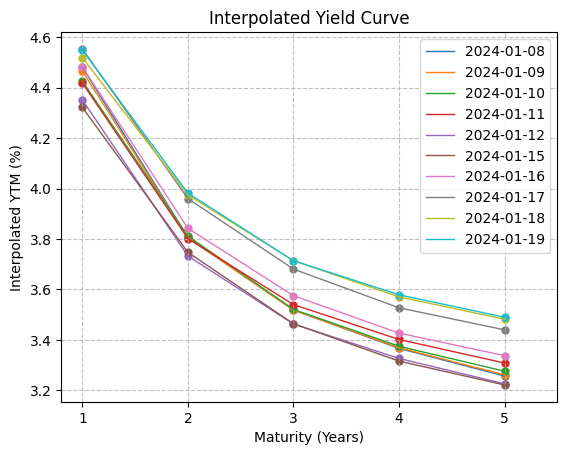

In [58]:
lstYrs = [1, 2, 3, 4, 5]
for strDate in dfYTMInterpolate.columns:
  dtDate = datetime.strptime(strDate, '%Y-%m-%d').date()
  npYTM = np.array(list(dfYTMInterpolate[strDate])) * 100
  plt.plot(lstYrs, npYTM, label=strDate, linewidth=1)
  plt.scatter(lstYrs, npYTM, s=25)


plt.title('Interpolated Yield Curve')
plt.xlabel('Maturity (Years)')
plt.ylabel('Interpolated YTM (%)')
plt.xlim(0.8, 5.5)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.8)
plt.show()

## Q4(b): Spot Calculation

### Spot Curve

In [59]:
# helper functions
def solve_rates(PV, FV, T):
  fltRate = -1/T * np.log(PV/FV)
  return fltRate

def calc_spot(dtCurrent, dtMaturity, fltDirtyPrice, fltCoupon, FV, dictSpotRates):
  lstCouponDates = find_next_coupon_date(dtCurrent, dtMaturity, return_list=True)
  lstYears = [convert_years(dtCurrent, dtCoupon) for dtCoupon in lstCouponDates]
  lstDays = [convert_days(dtCurrent, dtCoupon) for dtCoupon in lstCouponDates]
  lstCashFlows = [(fltCoupon*FV/2) for _ in range(len(lstYears))]
  lstCashFlows[-1] += FV
  # if only 1 payment - analogous to a zero-coupon bond
  if len(lstYears) == 1:
    fltRates = solve_rates(fltDirtyPrice, lstCashFlows[0], lstYears[0])
    dictSpotRates[lstDays[0]] = fltRates
  # more than 1 payment - discount other CFs using known rates
  else:
    lstSpot = []
    for i in range(len(lstDays)-1):
      lstSpot.append(dictSpotRates[lstDays[i]])
    npSpot, npYears, npCFs = np.array(lstSpot), np.array(lstYears[:-1]), np.array(lstCashFlows[:-1])
    fltDiscountCFs = np.sum(npCFs * np.exp(-(npSpot*npYears)))
    PV = fltDirtyPrice - fltDiscountCFs
    fltRates = solve_rates(PV, lstCashFlows[-1], lstYears[-1])
    dictSpotRates[lstDays[-1]] = fltRates
  return (fltRates, dictSpotRates)

In [60]:
dictSpotRates = {}
dfBondSpot10 = pd.DataFrame(index=lstSelectedBonds, columns=lstCurrentDates)
lstCurrentDates = list(dfBondSpot10.columns)
FV = 100
for bond in dfBondSpot10.index:
  fltCoupon = dictBondInfo10[bond]['Coupon']
  dtMaturity = dictBondInfo10[bond]['Maturity Date']
  lstSpot = []
  for i in range(len(lstCurrentDates)):
    dtCurrent = datetime.strptime(lstCurrentDates[i], '%Y-%m-%d').date()
    fltDirtyPrice = dfBondDirtyPrice10.loc[bond][lstCurrentDates[i]]
    fltSpot, dictSpotRates = calc_spot(dtCurrent, dtMaturity, fltDirtyPrice, fltCoupon, FV, dictSpotRates)
    lstSpot.append(fltSpot)
  dfBondSpot10.loc[bond] = lstSpot


In [61]:
dfBondSpot10

,2024-01-08,2024-01-09,2024-01-10,2024-01-11,2024-01-12,2024-01-15,2024-01-16,2024-01-17,2024-01-18,2024-01-19
CA135087J546,0.047823,0.047613,0.047395,0.047095,0.046932,0.047191,0.048307,0.048649,0.047149,0.046702
CA135087J967,0.046629,0.046447,0.046502,0.046685,0.046196,0.046068,0.047506,0.047631,0.047383,0.047395
CA135087K528,0.04405,0.043925,0.043359,0.043213,0.042507,0.042227,0.043919,0.044853,0.044495,0.044902
CA135087K940,0.040397,0.040263,0.040258,0.039992,0.039662,0.039838,0.04035,0.041523,0.041652,0.041845
CA135087L518,0.03708,0.037135,0.03726,0.037245,0.036445,0.036652,0.037773,0.038972,0.039142,0.039194
CA135087L930,0.035714,0.035825,0.035397,0.035508,0.035251,0.035455,0.036177,0.037362,0.037559,0.037628
CA135087M847,0.034873,0.034826,0.035046,0.035276,0.03431,0.034275,0.035526,0.036545,0.036933,0.036914
CA135087N837,0.034122,0.034095,0.034067,0.034326,0.033684,0.033599,0.034576,0.035615,0.036037,0.036069
CA135087P576,0.033149,0.033205,0.03332,0.033617,0.032815,0.032714,0.033883,0.034875,0.035337,0.035441
CA135087Q491,0.032545,0.032596,0.032599,0.03301,0.032243,0.032171,0.03326,0.034308,0.034742,0.034838


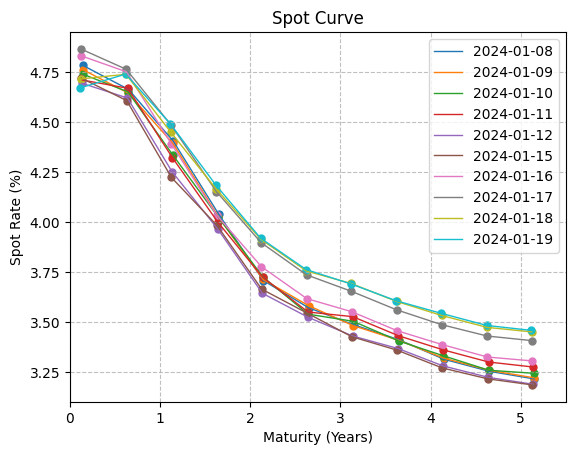

In [62]:
for strDate in dfBondSpot10.columns:
  dtDate = datetime.strptime(strDate, '%Y-%m-%d').date()
  npSpot = np.array(list(dfBondSpot10[strDate])) * 100
  lstMaturity = []
  for bond in dfBondSpot10.index:
    fltYears = convert_years(dtDate, dictBondInfo10[bond]['Maturity Date'])
    lstMaturity.append(fltYears)
  plt.plot(lstMaturity, npSpot, label=strDate, linewidth=1)
  plt.scatter(lstMaturity, npSpot, s=25)


plt.title('Spot Curve')
plt.xlabel('Maturity (Years)')
plt.ylabel('Spot Rate (%)')
plt.xlim(0, 5.5)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.8)
plt.show()

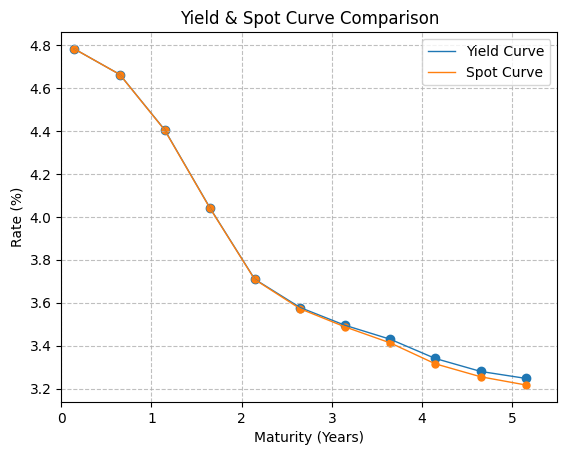

In [63]:
strDate = '2024-01-08'
dtDate = datetime.strptime(strDate, '%Y-%m-%d').date()
lstMaturity = []
for bond in dfBondSpot10.index:
    fltYears = convert_years(dtDate, dictBondInfo10[bond]['Maturity Date'])
    lstMaturity.append(fltYears)

# plot yield curve
npYTM = np.array(list(dfBondYTM10[strDate])) * 100
plt.plot(lstMaturity, npYTM, label='Yield Curve', linewidth=1)
plt.scatter(lstMaturity, npYTM)
# plot spot curve
npSpot = np.array(list(dfBondSpot10[strDate])) * 100
plt.plot(lstMaturity, npSpot, label='Spot Curve', linewidth=1)
plt.scatter(lstMaturity, npSpot, s=25)

plt.title('Yield & Spot Curve Comparison')
plt.xlabel('Maturity (Years)')
plt.ylabel('Rate (%)')
plt.xlim(0, 5.5)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.8)
plt.show()


### Interpolated Spot Curve

In [64]:
dfBondMaturity10 = get_maturity_info(lstSelectedBonds, lstCurrentDates, dictBondInfo10)
dfBondMaturity10

,2024-01-08,2024-01-09,2024-01-10,2024-01-11,2024-01-12,2024-01-15,2024-01-16,2024-01-17,2024-01-18,2024-01-19
CA135087J546,0.145205,0.142466,0.139726,0.136986,0.134247,0.126027,0.123288,0.120548,0.117808,0.115068
CA135087J967,0.649315,0.646575,0.643836,0.641096,0.638356,0.630137,0.627397,0.624658,0.621918,0.619178
CA135087K528,1.145205,1.142466,1.139726,1.136986,1.134247,1.126027,1.123288,1.120548,1.117808,1.115068
CA135087K940,1.649315,1.646575,1.643836,1.641096,1.638356,1.630137,1.627397,1.624658,1.621918,1.619178
CA135087L518,2.145205,2.142466,2.139726,2.136986,2.134247,2.126027,2.123288,2.120548,2.117808,2.115068
CA135087L930,2.649315,2.646575,2.643836,2.641096,2.638356,2.630137,2.627397,2.624658,2.621918,2.619178
CA135087M847,3.145205,3.142466,3.139726,3.136986,3.134247,3.126027,3.123288,3.120548,3.117808,3.115068
CA135087N837,3.649315,3.646575,3.643836,3.641096,3.638356,3.630137,3.627397,3.624658,3.621918,3.619178
CA135087P576,4.147945,4.145205,4.142466,4.139726,4.136986,4.128767,4.126027,4.123288,4.120548,4.117808
CA135087Q491,4.652055,4.649315,4.646575,4.643836,4.641096,4.632877,4.630137,4.627397,4.624658,4.621918


In [65]:
# interpolate spot curve
lstYears = ['Year 1', 'Year 2', 'Year 3', 'Year 4', 'Year 5']
dictInterpolate = {'Year 1': (1, 2), 'Year 2': (3, 4), 'Year 3': (5, 6), 'Year 4': (7, 8), 'Year 5': (9, 10)}
dfSpotInterpolate = interpolate_curve(dfBondSpot10, lstYears, lstCurrentDates, dictInterpolate, dfBondMaturity10)
dfSpotInterpolate

,2024-01-08,2024-01-09,2024-01-10,2024-01-11,2024-01-12,2024-01-15,2024-01-16,2024-01-17,2024-01-18,2024-01-19
Year 1,0.044805,0.044650,0.044245,0.044172,0.043506,0.043203,0.044811,0.045528,0.045181,0.045480
Year 2,0.038051,0.038033,0.038105,0.038003,0.037316,0.037462,0.038414,0.039592,0.039739,0.039810
Year 3,0.035119,0.035113,0.035145,0.035340,0.034565,0.034575,0.035688,0.036743,0.037082,0.037080
Year 4,0.033438,0.033464,0.033534,0.033816,0.033054,0.032942,0.034059,0.035058,0.035507,0.035590
Year 5,0.032280,0.032332,0.032491,0.032830,0.031993,0.031945,0.033115,0.034136,0.034570,0.034649


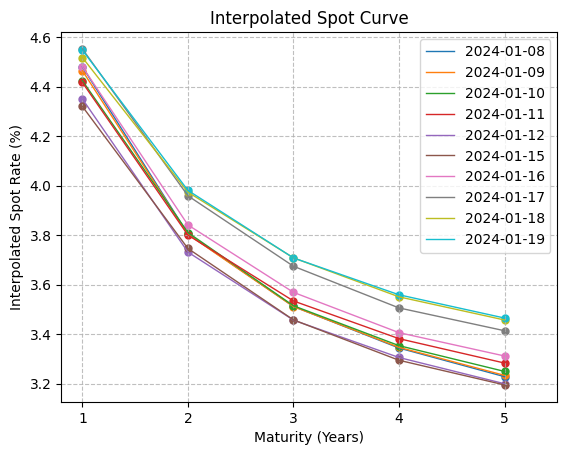

In [66]:
lstYrs = [1, 2, 3, 4, 5]
for strDate in dfSpotInterpolate.columns:
  dtDate = datetime.strptime(strDate, '%Y-%m-%d').date()
  npSpot = np.array(list(dfSpotInterpolate[strDate])) * 100
  plt.plot(lstYrs, npSpot, label=strDate, linewidth=1)
  plt.scatter(lstYrs, npSpot, s=25)


plt.title('Interpolated Spot Curve')
plt.xlabel('Maturity (Years)')
plt.ylabel('Interpolated Spot Rate (%)')
plt.xlim(0.8, 5.5)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.8)
plt.show()

## Q4(c): Forward Rate Calculation

### Method 1: Calculate 1-Year Forward Curve using Interpolated Spot Curve

In [67]:
npSpot1, npSpot2 = np.array(dfSpotInterpolate)[:-1, :], np.array(dfSpotInterpolate)[1:, :]
npMaturity = np.repeat([[1, 2, 3, 4, 5]], 10, axis=0).T
npMaturity1, npMaturity2 = npMaturity[:-1, :], npMaturity[1:, :]
npForward = (npSpot2*npMaturity2-npSpot1*npMaturity1) / (npMaturity2-npMaturity1)
dfBondForward10 = pd.DataFrame(npForward, index=lstYears[1:], columns=lstCurrentDates)
#dfForward1 = pd.DataFrame(npSpot1[0, :].reshape((1, 10)), index=[lstYears[0]], columns=lstCurrentDates)
#dfForward2 = pd.DataFrame(npForward, index=lstYears[1:], columns=lstCurrentDates)
#dfBondForward10 = pd.concat([dfForward1, dfForward2])

In [68]:
dfBondForward10

,2024-01-08,2024-01-09,2024-01-10,2024-01-11,2024-01-12,2024-01-15,2024-01-16,2024-01-17,2024-01-18,2024-01-19
Year 2,0.031298,0.031417,0.031965,0.031835,0.031125,0.031720,0.032017,0.033656,0.034296,0.034139
Year 3,0.029255,0.029271,0.029226,0.030012,0.029064,0.028800,0.030236,0.031046,0.031769,0.031619
Year 4,0.028393,0.028518,0.028699,0.029243,0.028521,0.028046,0.029170,0.030003,0.030780,0.031120
Year 5,0.027649,0.027802,0.028323,0.028887,0.027749,0.027957,0.029342,0.030450,0.030826,0.030887


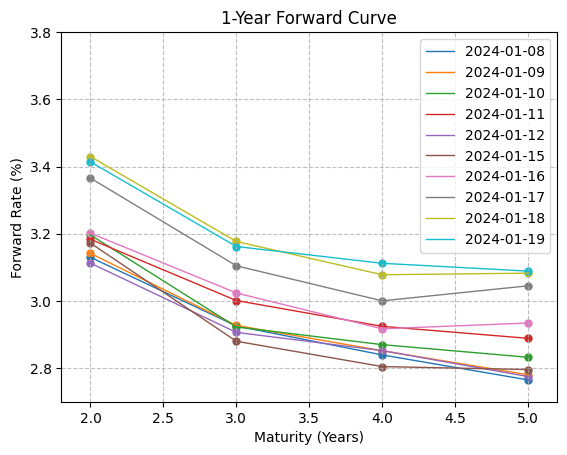

In [69]:
lstYrs = [2, 3, 4, 5]
for strDate in dfBondForward10.columns:
  dtDate = datetime.strptime(strDate, '%Y-%m-%d').date()
  npForward = np.array(list(dfBondForward10[strDate])) * 100
  plt.plot(lstYrs, npForward, label=strDate, linewidth=1)
  plt.scatter(lstYrs, npForward, s=25)


plt.title('1-Year Forward Curve')
plt.xlabel('Maturity (Years)')
plt.ylabel('Forward Rate (%)')
plt.xlim(1.8, 5.2)
plt.ylim(2.7, 3.8)
plt.legend(loc='upper right')
plt.grid(True, linestyle='--', alpha=0.8)
plt.show()

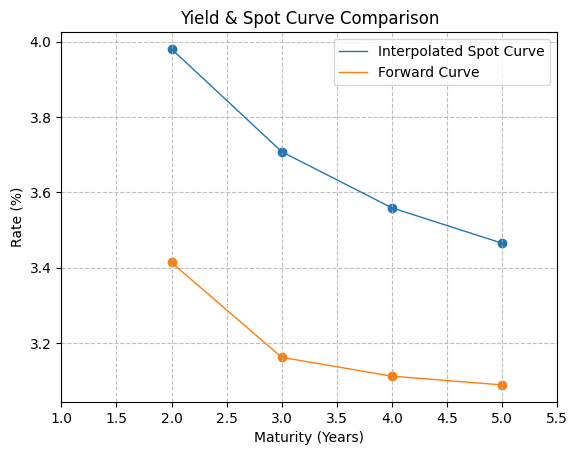

In [70]:
strDate = '2024-01-19'
dtDate = datetime.strptime(strDate, '%Y-%m-%d').date()

# plot interpolated spot curve
npSpot = np.array(list(dfSpotInterpolate[strDate]))[1:] * 100
plt.plot(lstYrs, npSpot, label='Interpolated Spot Curve', linewidth=1)
plt.scatter(lstYrs, npSpot)

# plot forward curve
npForward = np.array(list(dfBondForward10[strDate])) * 100
plt.plot(lstYrs, npForward, label='Forward Curve', linewidth=1)
plt.scatter(lstYrs, npForward)

plt.title('Yield & Spot Curve Comparison')
plt.xlabel('Maturity (Years)')
plt.ylabel('Rate (%)')
plt.xlim(1, 5.5)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.8)
plt.show()

### Method 2: Interpolate the Foward Curve

In [71]:
'''
dfBondMaturity10 = get_maturity_info(lstSelectedBonds, lstCurrentDates, dictBondInfo10)
npSpot1, npSpot2 = np.array(dfBondSpot10)[:-2, :], np.array(dfBondSpot10)[2:, :]
npMaturity1, npMaturity2 = np.array(dfBondMaturity10)[:-2, :], np.array(dfBondMaturity10)[2:, :]
npForward = (npSpot2*npMaturity2-npSpot1*npMaturity1) / (npMaturity2-npMaturity1)
dfBondForward10 = pd.DataFrame(npForward, index=lstSelectedBonds[2:], columns=lstCurrentDates)

#dfForward1 = pd.DataFrame(npSpot1[0, :].reshape((1, 10)), index=[lstSelectedBonds[0]], columns=lstCurrentDates)
#dfForward2 = pd.DataFrame(npForward, index=lstSelectedBonds[1:], columns=lstCurrentDates)
#dfBondForward10 = pd.concat([dfForward1, dfForward2])
for strDate in dfBondForward10.columns:
  dtDate = datetime.strptime(strDate, '%Y-%m-%d').date()
  npForward = np.array(list(dfBondForward10[strDate])) * 100
  lstMaturity = []
  for bond in dfBondForward10.index:
    fltYears = convert_years(dtDate, dictBondInfo10[bond]['Maturity Date'])
    lstMaturity.append(fltYears)
  plt.plot(lstMaturity, npForward, label=strDate, linewidth=1)
  plt.scatter(lstMaturity, npForward)


plt.title('1-Year Forward Curve')
plt.xlabel('Maturity (Years)')
plt.ylabel('1-Year Forward Rate (%)')
plt.xlim(0.8, 5.5)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.8)
plt.show()
'''

"\ndfBondMaturity10 = get_maturity_info(lstSelectedBonds, lstCurrentDates, dictBondInfo10)\nnpSpot1, npSpot2 = np.array(dfBondSpot10)[:-2, :], np.array(dfBondSpot10)[2:, :]\nnpMaturity1, npMaturity2 = np.array(dfBondMaturity10)[:-2, :], np.array(dfBondMaturity10)[2:, :]\nnpForward = (npSpot2*npMaturity2-npSpot1*npMaturity1) / (npMaturity2-npMaturity1)\ndfBondForward10 = pd.DataFrame(npForward, index=lstSelectedBonds[2:], columns=lstCurrentDates)\n\n#dfForward1 = pd.DataFrame(npSpot1[0, :].reshape((1, 10)), index=[lstSelectedBonds[0]], columns=lstCurrentDates)\n#dfForward2 = pd.DataFrame(npForward, index=lstSelectedBonds[1:], columns=lstCurrentDates)\n#dfBondForward10 = pd.concat([dfForward1, dfForward2])\nfor strDate in dfBondForward10.columns:\n  dtDate = datetime.strptime(strDate, '%Y-%m-%d').date()\n  npForward = np.array(list(dfBondForward10[strDate])) * 100\n  lstMaturity = []\n  for bond in dfBondForward10.index:\n    fltYears = convert_years(dtDate, dictBondInfo10[bond]['Maturit

In [72]:
'''
# interpolate forward curve
lstYears = ['Year 2', 'Year 3', 'Year 4', 'Year 5']
dictInterpolate = {'Year 2': (1, 2), 'Year 3': (3, 4), 'Year 4': (5, 6), 'Year 5': (7, 8)}
dfForwardInterpolate = interpolate_curve(dfBondForward10, lstYears, lstCurrentDates, dictInterpolate, dfBondMaturity10)
dfForwardInterpolate
'''

"\n# interpolate forward curve\nlstYears = ['Year 2', 'Year 3', 'Year 4', 'Year 5']\ndictInterpolate = {'Year 2': (1, 2), 'Year 3': (3, 4), 'Year 4': (5, 6), 'Year 5': (7, 8)}\ndfForwardInterpolate = interpolate_curve(dfBondForward10, lstYears, lstCurrentDates, dictInterpolate, dfBondMaturity10)\ndfForwardInterpolate\n"

In [73]:
'''
lstYrs = [2, 3, 4, 5]
for strDate in dfForwardInterpolate.columns:
  dtDate = datetime.strptime(strDate, '%Y-%m-%d').date()
  npForward = np.array(list(dfForwardInterpolate[strDate])) * 100
  plt.plot(lstYrs, npForward, label=strDate, linewidth=1)
  plt.scatter(lstYrs, npForward)


plt.title('1-Year Forward Curve')
plt.xlabel('Maturity (Years)')
plt.ylabel('Forward Rate (%)')
plt.xlim(1.8, 5.2)
plt.ylim(2.7, 4)
plt.legend(loc='upper right')
plt.grid(True, linestyle='--', alpha=0.8)
plt.show()
'''

"\nlstYrs = [2, 3, 4, 5]\nfor strDate in dfForwardInterpolate.columns:\n  dtDate = datetime.strptime(strDate, '%Y-%m-%d').date()\n  npForward = np.array(list(dfForwardInterpolate[strDate])) * 100\n  plt.plot(lstYrs, npForward, label=strDate, linewidth=1)\n  plt.scatter(lstYrs, npForward)\n\n\nplt.title('1-Year Forward Curve')\nplt.xlabel('Maturity (Years)')\nplt.ylabel('Forward Rate (%)')\nplt.xlim(1.8, 5.2)\nplt.ylim(2.7, 4)\nplt.legend(loc='upper right')\nplt.grid(True, linestyle='--', alpha=0.8)\nplt.show()\n"

## Q5 & Q6: Covariance Matrix & Eigenvalues/Eigenvectors

### Covariance Matrix - YTM

In [74]:
dfYTMInterpolate

,2024-01-08,2024-01-09,2024-01-10,2024-01-11,2024-01-12,2024-01-15,2024-01-16,2024-01-17,2024-01-18,2024-01-19
Year 1,0.044814,0.044659,0.044256,0.044184,0.043518,0.043217,0.044823,0.045538,0.045190,0.045488
Year 2,0.038065,0.038046,0.038117,0.038016,0.037328,0.037473,0.038426,0.039603,0.039749,0.039820
Year 3,0.035188,0.035182,0.035210,0.035401,0.034631,0.034642,0.035753,0.036808,0.037142,0.037141
Year 4,0.033664,0.033687,0.033748,0.034018,0.033264,0.033160,0.034272,0.035274,0.035707,0.035789
Year 5,0.032569,0.032616,0.032760,0.033085,0.032261,0.032215,0.033377,0.034400,0.034821,0.034900


In [75]:
lstYears = ['X1', 'X2', 'X3', 'X4', 'X5']
npYTM = np.array(dfYTMInterpolate)
npYTM1, npYTM2 = npYTM[:, :-1], npYTM[:, 1:]
npX = np.log(npYTM2/npYTM1)
dfX = pd.DataFrame(npX, index=lstYears, columns=lstCurrentDates[1:]).T
dfXCov = dfX.cov()
dfX

,X1,X2,X3,X4,X5
2024-01-09,-0.003478,-0.000485,-0.000192,0.000679,0.001448
2024-01-10,-0.009071,0.001858,0.000818,0.001817,0.004403
2024-01-11,-0.001631,-0.002665,0.005397,0.007971,0.009875
2024-01-12,-0.015166,-0.018250,-0.021990,-0.022400,-0.025220
2024-01-15,-0.006961,0.003885,0.000308,-0.003136,-0.001416
2024-01-16,0.036495,0.025107,0.031573,0.032963,0.035421
2024-01-17,0.015831,0.030176,0.029089,0.028832,0.030186
2024-01-18,-0.007672,0.003668,0.009022,0.012208,0.012174
2024-01-19,0.006565,0.001792,-0.000015,0.002295,0.002259


In [76]:
dfXCov

,X1,X2,X3,X4,X5
X1,0.000254,0.000193,0.000221,0.000226,0.000239
X2,0.000193,0.000211,0.000228,0.000227,0.000242
X3,0.000221,0.000228,0.000264,0.000270,0.000288
X4,0.000226,0.000227,0.000270,0.000279,0.000297
X5,0.000239,0.000242,0.000288,0.000297,0.000318


In [77]:
npXCov = np.array(dfXCov)
eigenvaluesX, eigenvectorsX = eig(npXCov)
print(f'Eigenvalues: {eigenvaluesX}\n')
print(f'Eigenvectors: {eigenvectorsX}\n')
print(f'Largest Eigenvalue: {eigenvaluesX[0]}\n')
print(f'Variance Explained by the Largest Eigenvalue: {(eigenvaluesX/np.sum(eigenvaluesX))[0] * 100}\n')
print(f'Eigenvector Associated with the Largest Eigenvalue: {eigenvectorsX[:, 0]}\n')

Eigenvalues: [1.24713568e-03 5.90764388e-05 1.97981367e-05 7.59404754e-07
 6.56231065e-07]

Eigenvectors: [[-0.40567283 -0.91157876 -0.0605634  -0.02771848 -0.00418063]
 [-0.39586554  0.12093963  0.86990835 -0.12050894  0.23958535]
 [-0.45790238  0.19315683  0.03210457  0.39550594 -0.77172547]
 [-0.46876187  0.21186792 -0.33156601  0.52856814  0.58826355]
 [-0.49930727  0.26870093 -0.35864303 -0.7408779  -0.0310995 ]]

Largest Eigenvalue: 0.0012471356805896965

Variance Explained by the Largest Eigenvalue: 93.95143549719059

Eigenvector Associated with the Largest Eigenvalue: [-0.40567283 -0.39586554 -0.45790238 -0.46876187 -0.49930727]



In [78]:
s=''
for row in eigenvectorsX:
  l = []
  for r in row:
    l.append(str(round(r,4)))
  s += '&'.join(l)
  s+='\\'
s

'-0.4057&-0.9116&-0.0606&-0.0277&-0.0042\\-0.3959&0.1209&0.8699&-0.1205&0.2396\\-0.4579&0.1932&0.0321&0.3955&-0.7717\\-0.4688&0.2119&-0.3316&0.5286&0.5883\\-0.4993&0.2687&-0.3586&-0.7409&-0.0311\\'

In [79]:
print(eigenvaluesX)

[1.24713568e-03 5.90764388e-05 1.97981367e-05 7.59404754e-07
 6.56231065e-07]


### Covariance Matrix - Forward Rate

In [80]:
dfForwardInterpolate = dfBondForward10
lstYears = ['1yr-1yr', '1yr-2yr', '1yr-3yr', '1yr-4yr']
npForward = np.array(dfForwardInterpolate)
npForward1, npForward2 = npForward[:, :-1], npForward[:, 1:]
npForwardX = np.log(npForward2/npForward1)
dfForwardX = pd.DataFrame(npForwardX, index=lstYears, columns=lstCurrentDates[1:]).T
dfForwardXCov = dfForwardX.cov()
dfForwardX

,1yr-1yr,1yr-2yr,1yr-3yr,1yr-4yr
2024-01-09,0.003800,0.000572,0.004381,0.005522
2024-01-10,0.017293,-0.001550,0.006325,0.018571
2024-01-11,-0.004077,0.026542,0.018793,0.019706
2024-01-12,-0.022536,-0.032111,-0.024994,-0.040177
2024-01-15,0.018933,-0.009117,-0.016812,0.007480
2024-01-16,0.009310,0.048671,0.039296,0.048353
2024-01-17,0.049916,0.026425,0.028150,0.037037
2024-01-18,0.018844,0.023027,0.025576,0.012280
2024-01-19,-0.004594,-0.004726,0.010973,0.001984


In [81]:
dfForwardXCov

,1yr-1yr,1yr-2yr,1yr-3yr,1yr-4yr
1yr-1yr,0.000414,0.000237,0.000201,0.000345
1yr-2yr,0.000237,0.000596,0.000481,0.000546
1yr-3yr,0.000201,0.000481,0.000437,0.000443
1yr-4yr,0.000345,0.000546,0.000443,0.000617


In [82]:
npForwardXCov = np.array(dfForwardXCov)
eigenvaluesForwardX, eigenvectorsForwardX = eig(npForwardXCov)
print(f'Eigenvalues: {eigenvaluesForwardX}\n')
print(f'Eigenvectors: {eigenvectorsForwardX}\n')
print(f'Largest Eigenvalue: {eigenvaluesForwardX[0]}\n')
print(f'Variance Explained by the Largest Eigenvalue: {(eigenvaluesForwardX/np.sum(eigenvaluesForwardX))[0]*100}\n')
print(f'Eigenvector Associated with the Largest Eigenvalue: {eigenvectorsForwardX[:, 0]}\n')

Eigenvalues: [1.70195297e-03 2.84499966e-04 5.50626770e-05 2.27200293e-05]

Eigenvectors: [[ 0.33508372  0.87273571  0.32168295 -0.15023771]
 [ 0.56674617 -0.36071515  0.04290752 -0.73948787]
 [ 0.47363411 -0.31254856  0.61190643  0.55095793]
 [ 0.58496873  0.10261756 -0.72128326  0.35641504]]

Largest Eigenvalue: 0.0017019529705841192

Variance Explained by the Largest Eigenvalue: 82.44954866235408

Eigenvector Associated with the Largest Eigenvalue: [0.33508372 0.56674617 0.47363411 0.58496873]



In [83]:
s=''
for row in eigenvectorsForwardX:
  l = []
  for r in row:
    l.append(str(round(r,4)))
  s += '&'.join(l)
  s+='\\'
s

'0.3351&0.8727&0.3217&-0.1502\\0.5667&-0.3607&0.0429&-0.7395\\0.4736&-0.3125&0.6119&0.551\\0.585&0.1026&-0.7213&0.3564\\'

## Rough Work

In [84]:
from scipy.optimize import fsolve

def findYTM(fltDirtyPrice, fltCoupon, FV, lstCashFlows, lstYears, step=0.001, epsilon=0.01):
  fltGuess = fltCoupon
  npCF = np.array(lstCashFlows)
  npYrs = np.array(lstYears)

  def equation(r):
    npDiscount = np.exp(-(npYrs*r)) # exp(-rT)
    PV = np.sum(npCF*npDiscount)
    return PV - fltDirtyPrice

  solution = fsolve(equation, fltGuess)
  return solution[0]

def calc_YTM(dtCurrent, dtMaturity, fltDirtyPrice, fltCoupon, FV):
  lstCouponDates = find_next_coupon_date(dtCurrent, dtMaturity, return_list=True)
  lstYears = [convert_years(dtCurrent, dtCoupon) for dtCoupon in lstCouponDates]
  lstCashFlows = [(fltCoupon*FV/2) for _ in range(len(lstYears))]
  lstCashFlows[-1] += FV
  #print(lstCashFlows)
  #print(lstYears)
  #print(fltLowerPV, fltUpperPV)
  #print(fltLowerRate, fltUpperRate)
  fltYTM = findYTM(fltDirtyPrice, fltCoupon, FV, lstCashFlows, lstYears, step=0.001, epsilon=0.1)
  return fltYTM

In [86]:
dfBondForward10

,2024-01-08,2024-01-09,2024-01-10,2024-01-11,2024-01-12,2024-01-15,2024-01-16,2024-01-17,2024-01-18,2024-01-19
Year 2,0.031298,0.031417,0.031965,0.031835,0.031125,0.031720,0.032017,0.033656,0.034296,0.034139
Year 3,0.029255,0.029271,0.029226,0.030012,0.029064,0.028800,0.030236,0.031046,0.031769,0.031619
Year 4,0.028393,0.028518,0.028699,0.029243,0.028521,0.028046,0.029170,0.030003,0.030780,0.031120
Year 5,0.027649,0.027802,0.028323,0.028887,0.027749,0.027957,0.029342,0.030450,0.030826,0.030887
